In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan

%matplotlib inline

In [3]:
df = pd.read_hdf("../data/gsf/2019-10-16_IPTG_Select-DNA-5-plates_BarSeqFitnessFrame.hdf")
df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,forward_BC,reverse_BC,A1,A2,A3,A4,A5,A6,A7,A8,...,High Level error,IC50,IC50 error,n,n error,High Level - Low Level,High Level - Low Level error,fitness_0_estimate_var,f_dist,r_dist
0,ACTCACATCTCACACTTGCGAATTCACAACTCGGACT,CGTCGAAAGTTAAATTTTTGTTTTAATACTTCAAAGG,598881,518796,500772,1027505,1021196,983274,2255353,1861908,...,NaN,1267.134591,NaN,4.999958,NaN,9.646610e+02,NaN,1.719632e-04,19.0,19.0
1,CCTAGGACCTTCAAGATGTAAGATGTCAATTCGTAAC,TATTCGATATTGAACATCAATAGTAGGAACTACTACT,413436,363085,383832,390062,369658,375354,435352,362696,...,NaN,749.652071,NaN,1.011659,NaN,-2.014372e-07,NaN,4.930381e-32,17.0,19.0
2,TTTGTAATTTCTGAACTTGAAGATAACATCTCATATC,AATTGGACCTCAAAGGTCCTTTTTTTAACCTCTGACA,339519,301020,324140,324374,310918,313176,368612,309478,...,NaN,27.343367,NaN,2.331292,NaN,-3.117173e+03,NaN,5.805875e-05,0.0,0.0
3,ACTTTGATTTCGCAAATGGGATCTATTACATGGGATT,TTTTTTAGCTCCAAACTTGTTAATGCTAGGTCTTATC,3865,3438,3859,4828,4761,4746,6813,5919,...,NaN,3109.240370,NaN,4.999945,NaN,1.528244e+03,NaN,1.353823e-04,18.0,20.0
5,GATGGCACATGTTACGTCCGACGTGACATCTATGAAG,TATGTGAGCTCGCACTTACATCCTTCCATTTGGCAGT,3336,2978,3177,3392,3286,3472,3737,3362,...,NaN,170.522001,NaN,1.912371,NaN,1.270941e+03,NaN,5.126729e-05,19.0,20.0


In [364]:
df.columns.tolist()

['forward_BC',
 'reverse_BC',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G7',
 'G8',
 'G9',
 'G10',
 'G11',
 'G12',
 'H1',
 'H2',
 'H3',
 'H4',
 'H5',
 'H6',
 'H7',
 'H8',
 'H9',
 'H10',
 'H11',
 'H12',
 'total_counts',
 'possibleChimera',
 'parent_geo_mean',
 'fraction_A1',
 'fraction_A2',
 'fraction_A3',
 'fraction_A4',
 'fraction_A5',
 'fraction_A6',
 'fraction_A7',
 'fraction_A8',
 'fraction_A9',
 'fraction_A10',
 'fraction_A11',
 'fraction_A12',
 'fraction_B1',
 'frac

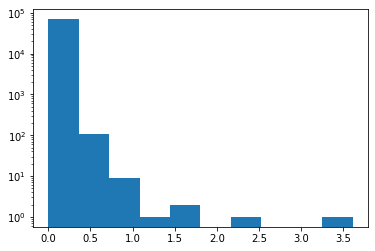

In [366]:
plt.hist(df.sensor_rms_residuals, log=True);

In [32]:
def fitness_mean(x):
    ylo = x.fitness_0_estimate_b
    yhi = x.fitness_20_estimate_b
    y = (yhi-ylo)/ylo
    
    return y

def fitness_err(x):
    ylo = x.fitness_0_estimate_b
    slo = x.fitness_0_err_b
    shi = x.fitness_20_err_b
    s = np.sqrt( shi**2 + slo**2 )/ylo
    
    return s

def init_stan_fit(x_data, y_data, fit_fitness_difference_params):
    log_low_level = log_level(np.mean(y_data[:2]))
    log_high_level = log_level(np.mean(y_data[-2:]))
    
    min_ic = np.log10(min([i for i in x_data if i>0]))
    max_ic = np.log10(max(x_data))
    log_IC_50 = np.random.uniform(min_ic, max_ic)
    
    n = np.random.uniform(1.3, 1.7)
    
    sig = np.random.uniform(1, 3)
    
    low_fitness = fit_fitness_difference_params[0]
    mid_g = fit_fitness_difference_params[1]
    fitness_n = fit_fitness_difference_params[2]
    
    return dict(log_low_level=log_low_level, log_high_level=log_high_level, log_IC_50=log_IC_50,
                sensor_n=n, sigma=sig, low_fitness=low_fitness, mid_g=mid_g, fitness_n=fitness_n)

def log_level(fitness_difference):
    log_g = 1.439*fitness_difference + 3.32
    log_g = log_g*np.random.uniform(0.9,1.1)
    if log_g<1.5:
        log_g = 1.5
    if log_g>4:
        log_g = 4
    return log_g


In [21]:
tmp = df.apply(fitness_mean, axis=1)
tmp = np.array(tmp.values.tolist())

for i in range(12):
    df['relfit_{}_mean'.format(i)] = tmp[:, i].astype(float)
    
df.head()

,forward_BC,reverse_BC,A1,A2,A3,A4,A5,A6,A7,A8,...,relfit_2_err,relfit_3_err,relfit_4_err,relfit_5_err,relfit_6_err,relfit_7_err,relfit_8_err,relfit_9_err,relfit_10_err,relfit_11_err
0,ACTCACATCTCACACTTGCGAATTCACAACTCGGACT,CGTCGAAAGTTAAATTTTTGTTTTAATACTTCAAAGG,598881,518796,500772,1027505,1021196,983274,2255353,1861908,...,0.000752,0.001124,0.000740,0.000745,0.000779,0.000876,0.000755,0.001313,0.000715,0.000804
1,CCTAGGACCTTCAAGATGTAAGATGTCAATTCGTAAC,TATTCGATATTGAACATCAATAGTAGGAACTACTACT,413436,363085,383832,390062,369658,375354,435352,362696,...,0.000771,0.001175,0.000752,0.000685,0.000814,0.000839,0.000681,0.001311,0.000723,0.001169
2,TTTGTAATTTCTGAACTTGAAGATAACATCTCATATC,AATTGGACCTCAAAGGTCCTTTTTTTAACCTCTGACA,339519,301020,324140,324374,310918,313176,368612,309478,...,0.000787,0.001195,0.000766,0.000700,0.000846,0.000873,0.000684,0.001350,0.000771,0.001228
3,ACTTTGATTTCGCAAATGGGATCTATTACATGGGATT,TTTTTTAGCTCCAAACTTGTTAATGCTAGGTCTTATC,3865,3438,3859,4828,4761,4746,6813,5919,...,0.008436,0.013490,0.008521,0.008403,0.008771,0.010515,0.008555,0.014935,0.010323,0.012305
5,GATGGCACATGTTACGTCCGACGTGACATCTATGAAG,TATGTGAGCTCGCACTTACATCCTTCCATTTGGCAGT,3336,2978,3177,3392,3286,3472,3737,3362,...,0.011770,0.019287,0.011630,0.011625,0.010983,0.010104,0.006349,0.011265,0.005615,0.008720


In [22]:
tmp = df.apply(fitness_err, axis=1)
tmp = np.array(tmp.values.tolist())

for i in range(12):
    df['relfit_{}_err'.format(i)] = tmp[:, i].astype(float)
    
df.head()

,forward_BC,reverse_BC,A1,A2,A3,A4,A5,A6,A7,A8,...,relfit_2_err,relfit_3_err,relfit_4_err,relfit_5_err,relfit_6_err,relfit_7_err,relfit_8_err,relfit_9_err,relfit_10_err,relfit_11_err
0,ACTCACATCTCACACTTGCGAATTCACAACTCGGACT,CGTCGAAAGTTAAATTTTTGTTTTAATACTTCAAAGG,598881,518796,500772,1027505,1021196,983274,2255353,1861908,...,0.000752,0.001124,0.000740,0.000745,0.000779,0.000876,0.000755,0.001313,0.000715,0.000804
1,CCTAGGACCTTCAAGATGTAAGATGTCAATTCGTAAC,TATTCGATATTGAACATCAATAGTAGGAACTACTACT,413436,363085,383832,390062,369658,375354,435352,362696,...,0.000771,0.001175,0.000752,0.000685,0.000814,0.000839,0.000681,0.001311,0.000723,0.001169
2,TTTGTAATTTCTGAACTTGAAGATAACATCTCATATC,AATTGGACCTCAAAGGTCCTTTTTTTAACCTCTGACA,339519,301020,324140,324374,310918,313176,368612,309478,...,0.000787,0.001195,0.000766,0.000700,0.000846,0.000873,0.000684,0.001350,0.000771,0.001228
3,ACTTTGATTTCGCAAATGGGATCTATTACATGGGATT,TTTTTTAGCTCCAAACTTGTTAATGCTAGGTCTTATC,3865,3438,3859,4828,4761,4746,6813,5919,...,0.008436,0.013490,0.008521,0.008403,0.008771,0.010515,0.008555,0.014935,0.010323,0.012305
5,GATGGCACATGTTACGTCCGACGTGACATCTATGAAG,TATGTGAGCTCGCACTTACATCCTTCCATTTGGCAGT,3336,2978,3177,3392,3286,3472,3737,3362,...,0.011770,0.019287,0.011630,0.011625,0.010983,0.010104,0.006349,0.011265,0.005615,0.008720


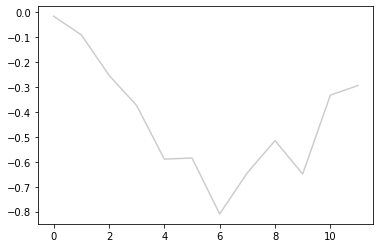

In [141]:
plt.plot(df.loc[62900, ["relfit_{}_mean".format(i) for i in range(12)]].values.T, c='k', alpha=.2);

In [155]:
low_fitness, mid_g, fitness_n = -7.41526290e-01,  7.75447318e+02,  2.78019804e+00
low_fitness, mid_g, fitness_n

(-0.74152629, 775.447318, 2.78019804)

In [91]:
inducer_conc = [0, 2]
for i in range(10):
    inducer_conc.append(2*inducer_conc[-1])

x = np.array(inducer_conc)
    
x

array([   0,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
       2048])

In [379]:
# model = pystan.StanModel("../stan/gp-hill.stan")
model = pystan.StanModel("../stan/gp-hill-nomean.stan")
# model = pystan.StanModel("../stan/hill-hill.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8076a69fa0c0a6bce262b8389a2e081d NOW.


In [368]:
df.sort_values("sensor_rms_residuals", ascending=False).head(12)

,forward_BC,reverse_BC,A1,A2,A3,A4,A5,A6,A7,A8,...,relfit_2_err,relfit_3_err,relfit_4_err,relfit_5_err,relfit_6_err,relfit_7_err,relfit_8_err,relfit_9_err,relfit_10_err,relfit_11_err
59943,CCTAGGACCTTCAAGATGTAAGATGTCAATTCGTAAC,TATTCGATATTGAACATCAGTAGTAGGAACTACGACG,0,0,0,0,0,0,130,104,...,-1.171934,-1.064243e+08,-0.856744,0.188625,NaN,0.455919,2.614004,NaN,0.309064,-3.244551e+08
19539,CCTAGGACCTTCAAGATGTAAGATGTCAATTCGTAAC,TATTCGATATTGAACATCAGTAGTAGGAACTACGAGT,1,2,2,2,1,2,471,377,...,0.522545,1.795672e-01,0.345600,-1.599080,6.196257e-02,0.117226,0.150588,-1.709601,0.303086,1.505576e+07
39179,ACTCAGATCTCACACTTGCGAATTCGCAACTCGGACT,CGTCGAAAGTTAAATTTTTGTTTTAATACTTCAAAGG,1,0,0,0,0,0,706,609,...,0.446082,NaN,0.632631,NaN,8.277645e+06,0.393637,0.905477,NaN,0.331483,NaN
58163,TTTGTGATTTCTGAACTTGAAGATAGCATCTCATATC,AATTGGACCTCAAAGGTCCTTTTTTTAACCTCTGACA,0,0,1,0,0,0,103,90,...,0.302368,NaN,0.395809,2.457595,1.133912e-01,46.502069,0.153762,1.162964,0.724791,-2.164625e+07
13775,ACTGGCAGCTCACACTTGCGAATTCACAACTCGGACG,CGTCGAAAGTTAAATTTTTGTTTTAATACTTCAAAGG,0,4,1,0,1,0,2,2,...,NaN,9.352318e-02,0.088872,0.098558,3.017157e-01,0.105814,0.070628,0.325897,0.095049,-1.066339e+07
62832,ATTTAGAAGTTGTACGTTCTACTTCTAAGTTTGCAAA,TTGCGACGTTGAATCTCGGTCGTCAAACCTTCTACA,118,124,143,20,31,17,2,13,...,0.137726,5.949558e-01,0.150699,0.141032,1.969398e-01,0.382181,0.428286,0.371376,0.595977,7.306817e-01
68603,ACTCACATCTCACACTTGCGAATTCACAACTCGGACT,TGGCCGGCCTGCTGGCATATAGTCCGAGTTGTGAATTCGCA,12,12,11,22,26,26,46,36,...,0.541515,6.062450e-01,0.412521,0.382645,4.297227e-01,0.278149,0.261026,0.300536,0.148843,1.187092e-01
70684,GCTTATAAGTCACACCTGTAATATAAAACCTTTCAGG,ACTTGCATATTCGACGTCCCTACTCAAAGCTTCAACT,30,17,29,4,36,1,6,15,...,0.244077,8.750450e-01,0.190515,0.345169,4.125695e-01,0.311611,0.255295,1.161005,0.669057,2.874375e-01
65682,ATTCGGAAGTTTAACATTAGACGTGAGAAATGCGAGC,TTTTTTATTTTGAAGCTTAATCGTGTAACATTTAACT,99,51,79,12,106,28,27,42,...,0.146847,3.785484e-01,0.086515,0.102933,1.508307e-01,0.162067,0.102413,0.260062,0.200478,2.466639e-01
69332,ACTCACATCTCACACTTGCGAATTCACAACTCGGACT,TTAACAATTGTAATATCTGTGTTGCCATCTTTCACA,13,9,3,23,15,20,44,34,...,0.547718,7.881943e-01,0.408641,0.788861,5.137490e-01,0.498201,0.343264,0.637671,0.256864,1.641947e-01


[]

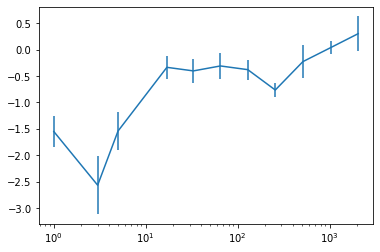

In [375]:
fit_mean = ["relfit_{}_mean".format(i) for i in range(12)]
fit_err = ["relfit_{}_err".format(i) for i in range(12)]

# ind = 62900
# ind = 57439
# ind = 37553
ind = 49394
ind = 69850

y = df.loc[ind, fit_mean].values.astype(float)
y_err = df.loc[ind, fit_err].values.astype(float)

valid = ~(np.isnan(y) | np.isnan(y_err))

# hack to remove first
# valid[0] = False

data = dict(
    x=x[valid], y=y[valid], N=len(y[valid]), y_err=y_err[valid],
    low_fitness_mu=low_fitness, mid_g_mu=mid_g, fitness_n_mu=fitness_n)

stan_init = [ init_stan_fit(x[valid], y[valid], (low_fitness, mid_g, fitness_n)) for i in range(4) ]
for i in range(4):
    stan_init[i]["rho"] = 1
    stan_init[i]["alpha"] = .01
    
plt.errorbar(1 + x[valid], y[valid], y_err[valid])
plt.semilogx()

In [386]:
stan_init

[{'log_low_level': 1.5,
  'log_high_level': 3.8549687516566524,
  'log_IC_50': 0.37019601073581376,
  'sensor_n': 1.6600108988847202,
  'sigma': 1.7216925938125116,
  'low_fitness': -0.74152629,
  'mid_g': 775.447318,
  'fitness_n': 2.78019804,
  'rho': 1,
  'alpha': 0.01},
 {'log_low_level': 1.5,
  'log_high_level': 3.499372352049931,
  'log_IC_50': 3.2540946823677612,
  'sensor_n': 1.6661047542985445,
  'sigma': 1.8960080932343417,
  'low_fitness': -0.74152629,
  'mid_g': 775.447318,
  'fitness_n': 2.78019804,
  'rho': 1,
  'alpha': 0.01},
 {'log_low_level': 1.5,
  'log_high_level': 3.446581225331011,
  'log_IC_50': 1.2940563774408536,
  'sensor_n': 1.675187507536726,
  'sigma': 1.8094862553458047,
  'low_fitness': -0.74152629,
  'mid_g': 775.447318,
  'fitness_n': 2.78019804,
  'rho': 1,
  'alpha': 0.01},
 {'log_low_level': 1.5,
  'log_high_level': 3.5962604843348744,
  'log_IC_50': 2.6136276889842565,
  'sensor_n': 1.456847250922614,
  'sigma': 2.0604026103921846,
  'low_fitness': 

In [380]:
samples = model.sampling(data=data, init=stan_init,)
samp = samples.extract()
samples

Inference for Stan model: anon_model_8076a69fa0c0a6bce262b8389a2e081d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
log_low_level    2.72    0.01   0.53   1.79    2.3   2.72   3.14   3.68   1977    1.0
log_high_level   2.75    0.01   0.53   1.79   2.34   2.76   3.16   3.71   1930    1.0
log_IC_50        1.79    0.03   1.21  -0.37   0.78   1.83   2.81   3.76   2083    1.0
sensor_n         1.19    0.01   0.59   0.34   0.75   1.08   1.52   2.56   2287    1.0
sigma            2.95    0.03   0.94   1.57   2.28   2.82   3.46   5.13    910    1.0
low_fitness     -0.74  1.1e-3   0.05  -0.84  -0.78  -0.74  -0.71  -0.65   2184    1.0
mid_g          775.49    0.18   9.44 756.94 769.31 775.31 781.85 794.29   2716    1.0
fitness_n        2.78  6.7e-4   0.03   2.72   2.76   2.78    2.8   2.84   1971    1.0
rho              1.27    0.02   0.69 

[]

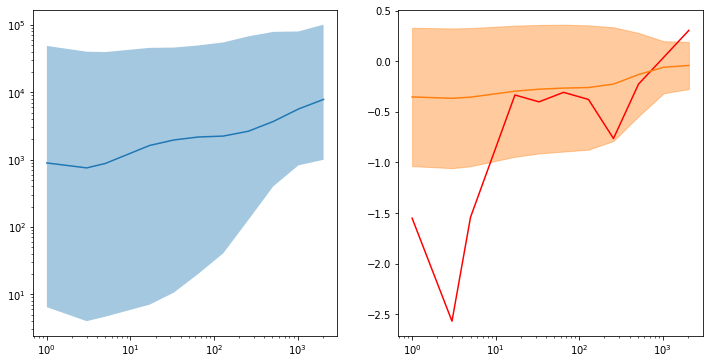

In [385]:
g = samp['g']
gmu = np.median(g, axis=0)
gstd = g.std(axis=0)
gmin = np.quantile(g, .05, axis=0)
gmax = np.quantile(g, .95, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(x[valid]+1, gmu)
# plt.fill_between(x+1, gmu-2*gstd, gmu+2*gstd, alpha=.4)
plt.fill_between(x[valid]+1, gmin, gmax, alpha=.4)
# plt.plot(x, samp['g_mu'].mean(axis=0))
plt.semilogx()
plt.semilogy()

g = samp['mean_y']
gmu = g.mean(axis=0)
gstd = g.std(axis=0)

plt.subplot(122)
plt.plot(x[valid]+1, y[valid], c='r');
plt.plot(x[valid]+1, gmu, c='C1')
plt.fill_between(x[valid]+1, gmu-2*gstd, gmu+2*gstd, alpha=.4, color='C1')
plt.semilogx()

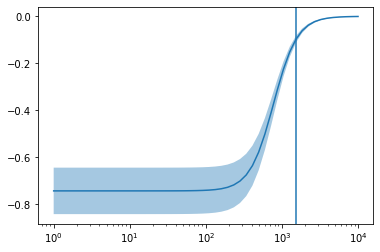

In [383]:
lf = samp['low_fitness']
mg = samp['mid_g']
nf = samp['fitness_n']

gx = np.logspace(0, 4)[:, None]

post = lf - lf*np.power(gx, nf)/(np.power(mg, nf) + np.power(gx, nf))

pmu = np.median(post, axis=1)
pstd = np.std(post, axis=1)

plt.plot(gx, pmu)
plt.fill_between(gx[:, 0], pmu-2*pstd, pmu+2*pstd, alpha=.4)
plt.semilogx();
plt.axvline(2*mid_g);

[]

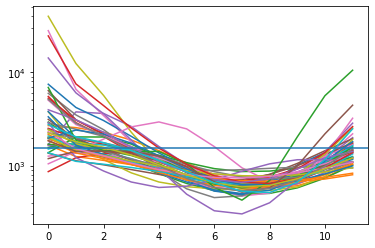

In [362]:
g = samp['g']
gmu = np.median(g, axis=0)
gstd = g.std(axis=0)
gmin = np.quantile(g, .05, axis=0)
gmax = np.quantile(g, .95, axis=0)
plt.plot(g[:50, :].T);
plt.axhline(mid_g*2)
plt.semilogy()

[]

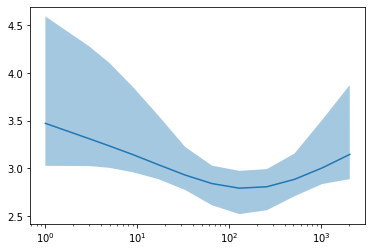

In [318]:
g = samp['g']
g = np.log10(g)
gmu = np.median(g, axis=0)
gstd = g.std(axis=0)
gmin = np.quantile(g, .025, axis=0)
gmax = np.quantile(g, .975, axis=0)

plt.plot(x[valid]+1, gmu)
# plt.fill_between(x+1, gmu-2*gstd, gmu+2*gstd, alpha=.4)
plt.fill_between(x[valid]+1, gmin, gmax, alpha=.4)
# plt.plot(x, samp['g_mu'].mean(axis=0))
plt.semilogx()

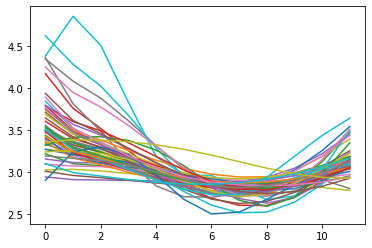

In [319]:
plt.plot(g[:50, :].T);

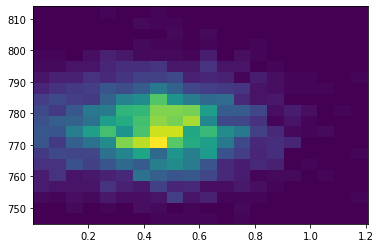

In [387]:
plt.hist2d(samp['alpha'], samp['mid_g'], bins=20);

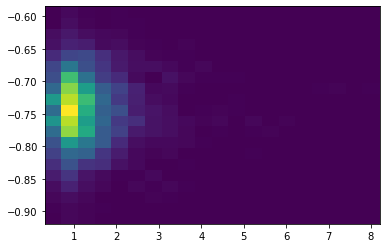

In [390]:
plt.hist2d(samp['rho'], samp['low_fitness'], bins=20);

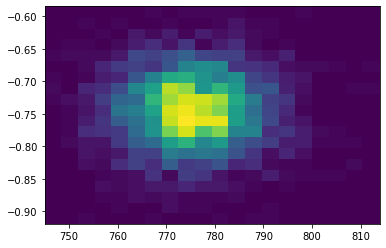

In [391]:
plt.hist2d(samp['mid_g'], samp['low_fitness'], bins=20);

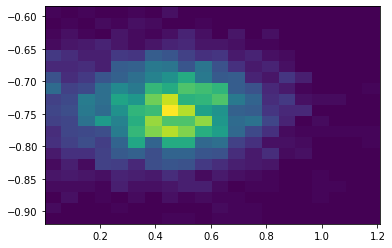

In [388]:
plt.hist2d(samp['alpha'], samp['low_fitness'], bins=20);

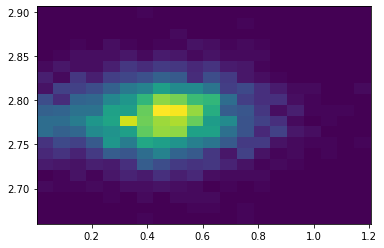

In [389]:
plt.hist2d(samp['alpha'], samp['fitness_n'], bins=20);

In [79]:
tmp = pystan.StanModel("../stan/gp-test.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f54be0f845d10ae1beb69670912bd5c NOW.


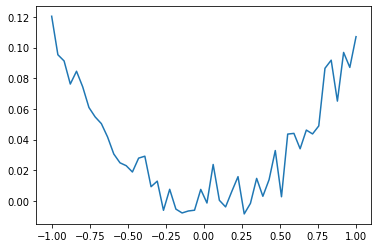

In [81]:
N = 50
x = np.linspace(-1, 1, N)
y = np.sin(x/np.pi)*x/3 + np.random.normal(scale=.01, size=N)

plt.plot(x, y);

In [82]:
samples = tmp.sampling({"N":N, "x":x, "y":y})

In [83]:
samples

Inference for Stan model: anon_model_4f54be0f845d10ae1beb69670912bd5c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       1.66    0.02   0.59   0.72   1.23   1.59   2.03   2.99   1071   1.01
alpha     0.37  6.6e-3   0.22   0.09   0.21   0.32   0.49   0.92   1116   1.01
sigma     0.01  1.9e-5 1.1e-3 8.7e-3 9.9e-3   0.01   0.01   0.01   3826    1.0
eta[1]    0.41  8.8e-3   0.27   0.12   0.22   0.34   0.51   1.13    936   1.01
eta[2]   -1.02  9.2e-3   0.37  -1.88  -1.24  -0.96  -0.74  -0.46   1618    1.0
eta[3]    0.83    0.01   0.61   -0.3   0.43   0.78   1.19   2.14   2325    1.0
eta[4]    0.26    0.02    1.0   -1.7   -0.4   0.24   0.94   2.24   4421    1.0
eta[5]    0.15    0.02   0.96  -1.73  -0.51   0.15   0.81   2.05   3740    1.0
eta[6]    0.17    0.02   0.96  -1.73  -0.49   0.17   0.83   2.05   3738    1.0
eta[7]    0.14    0.0